In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import WeibullAFTFitter, LogLogisticAFTFitter, ExponentialFitter
import seaborn as sns
import os


# Create output directory for figures if it doesn't exist
os.makedirs('figures', exist_ok=True)

# Set visualization style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

#  Load and Explore Data

In [12]:
# Load the dataset
df = pd.read_csv('Churn_Data_cleaned.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
display(df.head())

# Check for missing values in key columns
print("\nMissing values in key columns:")
display(df[['churn', 'months']].isnull().sum())

# Basic statistics of key variables
print("\nBasic statistics of key variables:")
display(df[['churn', 'months', 'totmrc_Mean', 'mou_Mean', 'rev_Mean', 'ovrmou_Mean']].describe())

Dataset shape: (54702, 108)


,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,Customer_ID,mail,phoneswap,retentioncall,acptcall,referrals,pcowner_binary,women,mailordr_binary,mailresp_binary
0,16.9900,10.25,16.99,0.0000,0.0,0.0,0.0,False,0.0,-4.25,...,1000003,False,True,False,False,False,True,False,True,True
1,38.0000,7.50,38.00,0.0000,0.0,0.0,0.0,False,0.0,-1.50,...,1000004,False,False,False,False,False,False,False,False,False
2,55.2300,570.50,71.98,0.0000,0.0,0.0,0.0,False,0.0,38.50,...,1000005,False,True,False,False,False,True,False,False,False
3,17.1450,0.00,16.99,0.0000,0.0,0.0,0.0,False,0.0,0.00,...,1000007,False,True,False,False,False,True,False,True,True
4,31.6625,25.50,29.99,0.2475,0.0,0.0,0.0,False,0.0,59.50,...,1000010,False,True,False,False,False,False,False,True,True



Missing values in key columns:


churn     0
months    0
dtype: int64


Basic statistics of key variables:


,months,totmrc_Mean,mou_Mean,rev_Mean,ovrmou_Mean
count,54702.000000,54702.000000,54702.000000,54702.000000,54702.000000
mean,19.881577,40.863002,317.996943,45.115069,18.148611
std,9.611030,20.192007,362.706635,27.921929,50.850918
min,7.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,29.990000,79.750000,30.260000,0.000000
50%,18.000000,39.990000,204.875000,37.237500,0.000000
75%,25.000000,49.990000,422.000000,53.890000,13.000000
max,61.000000,409.990000,4883.750000,776.270000,2278.000000


# Define Survival Time and Event Indicator


Churn distribution:
churn
False    27935
True     26767
Name: count, dtype: int64
Churn rate: 48.93%


C:\Users\felix\AppData\Local\Temp\ipykernel_18992\456857891.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Churn rate: {churn_counts[1] / len(df):.2%}")


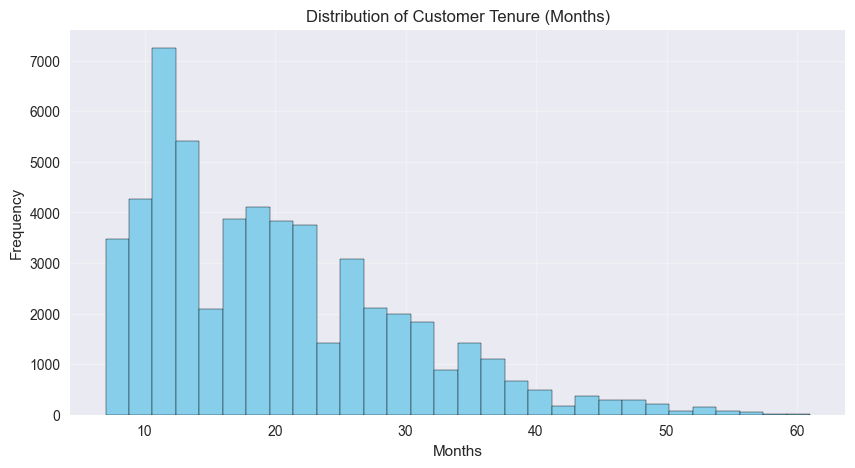

Tenure distribution plot saved to 'figures/tenure_distribution.png'


In [13]:
# Check churn distribution
churn_counts = df['churn'].value_counts()
print(f"\nChurn distribution:\n{churn_counts}")
print(f"Churn rate: {churn_counts[1] / len(df):.2%}")

# Visualize months distribution
plt.figure(figsize=(10, 5))
plt.hist(df['months'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Customer Tenure (Months)')
plt.xlabel('Months')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.savefig('figures/tenure_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Tenure distribution plot saved to 'figures/tenure_distribution.png'")

# Variable Selection

In [14]:
def explain_variable_selection(df):
    """
    Select and explain the rationale for choosing specific variables for survival analysis.
    """
    print("VARIABLE SELECTION EXPLANATION")
    print("-" * 50)
    
    # Customer identification variables
    id_vars = ['customer_id', 'area', 'region']
    print(f"Customer Identification Variables: {id_vars}")
    print("Rationale: These variables help identify and group customers geographically.")
    
    # Dependent variable: Tenure (duration until churn)
    duration_var = 'months'
    print(f"\nDuration Variable: {duration_var}")
    print("Rationale: Represents customer tenure - the time dimension in survival analysis.")
    
    # Event indicator: Churn
    event_var = 'churn'
    print(f"\nEvent Variable: {event_var}")
    print("Rationale: Binary indicator of whether a customer has churned (event occurred) or not (censored).")
    
    # Key predictor variables with business relevance
    predictor_vars = [
        'totmou',       # Total minutes of use
        'totrev',       # Total revenue
        'avgrev',       # Average monthly revenue
        'avgmou',       # Average monthly minutes of use
        'drop_blk_Range', # Call quality metric
        'new_cell',     # New customer indicator
        'asl_flag',     # Account spending limit flag
        'prizm_social_one', # Demographic segment
        'dualband'      # Technology adoption
    ]
    
    print("\nKey Predictor Variables:")
    
    print("Usage-related Variables:")
    print("- totmou: Total minutes of use")
    print("  Rationale: Direct indicator of service usage intensity.")
    print("- avgmou: Average monthly minutes of use")
    print("  Rationale: Indicates consistent usage patterns.")
    
    print("\nRevenue-related Variables:")
    print("- totrev: Total revenue")
    print("  Rationale: Direct business impact measure.")
    print("- avgrev: Average monthly revenue")
    print("  Rationale: Indicates customer value and spending consistency.")
    
    print("\nService Quality Variables:")
    print("- drop_blk_Range: Call quality metric")
    print("  Rationale: Poor service experience is a key churn driver.")
    
    print("\nCustomer Profile Variables:")
    print("- new_cell: New customer indicator")
    print("  Rationale: New customers often have different churn patterns.")
    print("- asl_flag: Account spending limit flag")
    print("  Rationale: Credit risk indicator that may affect retention.")
    print("- prizm_social_one: Demographic segment")
    print("  Rationale: Demographic factors influence customer behavior and loyalty.")
    print("- dualband: Technology adoption")
    print("  Rationale: Technology adopters may have different engagement and loyalty.")
    
    # Return the selected variables for further analysis
    selected_vars = id_vars + [duration_var, event_var] + predictor_vars
    return selected_vars, duration_var, event_var

selected_vars, duration_var, event_var = explain_variable_selection(df)
    


VARIABLE SELECTION EXPLANATION
--------------------------------------------------
Customer Identification Variables: ['customer_id', 'area', 'region']
Rationale: These variables help identify and group customers geographically.

Duration Variable: months
Rationale: Represents customer tenure - the time dimension in survival analysis.

Event Variable: churn
Rationale: Binary indicator of whether a customer has churned (event occurred) or not (censored).

Key Predictor Variables:
Usage-related Variables:
- totmou: Total minutes of use
  Rationale: Direct indicator of service usage intensity.
- avgmou: Average monthly minutes of use
  Rationale: Indicates consistent usage patterns.

Revenue-related Variables:
- totrev: Total revenue
  Rationale: Direct business impact measure.
- avgrev: Average monthly revenue
  Rationale: Indicates customer value and spending consistency.

Service Quality Variables:
- drop_blk_Range: Call quality metric
  Rationale: Poor service experience is a key churn

# Censoring Explanation


CENSORING APPROACH EXPLANATION
--------------------------------------------------
Total observations: 54702
Uncensored (churned) observations: 26767 (48.93%)
Right-censored observations: 27935 (51.07%)

Definition of Censoring in this Analysis:
- Event (churn=1): Customer has terminated service within the observation period.
- Right-censored (churn=0): Customer was still active at the end of the observation period.

Importance of Censoring:
- Right-censoring accounts for customers who haven't experienced the event by the
  end of the observation period but might do so in the future.
- Ignoring censoring would underestimate survival probabilities and lead to
  biased conclusions about customer lifetime.
- Survival analysis methods like Kaplan-Meier and parametric models properly
  account for censored observations in estimating survival functions.


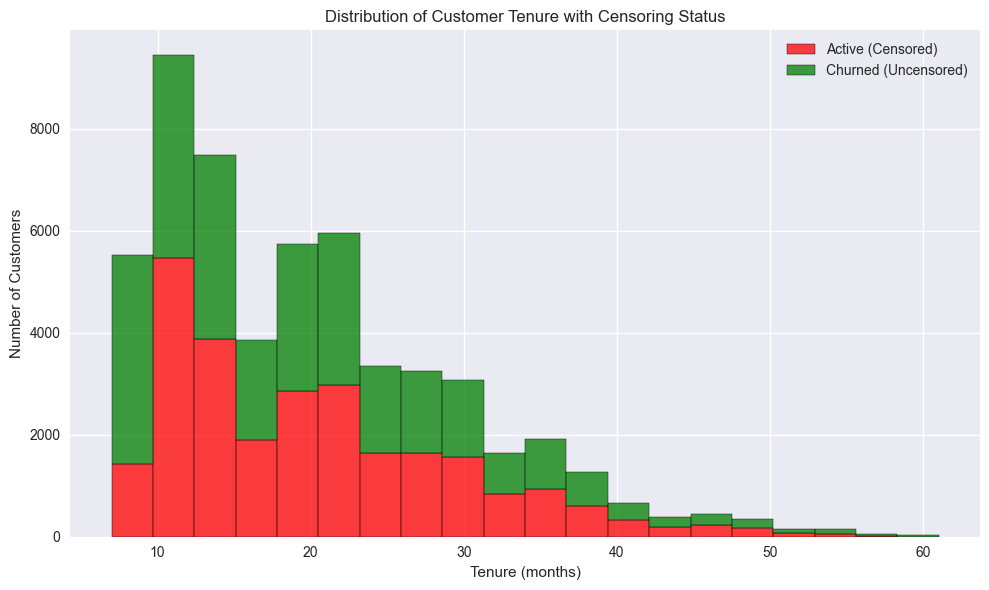

In [15]:
def explain_censoring_approach(df):
    """
    Provide a detailed explanation of the censoring approach used in the survival analysis.
    """
    print("\nCENSORING APPROACH EXPLANATION")
    print("-" * 50)
    
    # Count censored and uncensored observations
    censored_count = sum(df['churn'] == 0)
    uncensored_count = sum(df['churn'] == 1)
    total_count = len(df)
    
    print(f"Total observations: {total_count}")
    print(f"Uncensored (churned) observations: {uncensored_count} ({uncensored_count/total_count*100:.2f}%)")
    print(f"Right-censored observations: {censored_count} ({censored_count/total_count*100:.2f}%)")
    
    print("\nDefinition of Censoring in this Analysis:")
    print("- Event (churn=1): Customer has terminated service within the observation period.")
    print("- Right-censored (churn=0): Customer was still active at the end of the observation period.")
    
    print("\nImportance of Censoring:")
    print("- Right-censoring accounts for customers who haven't experienced the event by the")
    print("  end of the observation period but might do so in the future.")
    print("- Ignoring censoring would underestimate survival probabilities and lead to")
    print("  biased conclusions about customer lifetime.")
    print("- Survival analysis methods like Kaplan-Meier and parametric models properly")
    print("  account for censored observations in estimating survival functions.")
    
    # Create a visualization of censoring
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='months', hue='churn', bins=20, 
                 multiple='stack', palette=['green', 'red'])
    plt.xlabel('Tenure (months)')
    plt.ylabel('Number of Customers')
    plt.title('Distribution of Customer Tenure with Censoring Status')
    plt.legend(['Active (Censored)', 'Churned (Uncensored)'])
    plt.tight_layout()
    plt.savefig('censoring_visualization.png')
    plt.show()
    plt.close()
    


explain_censoring_approach(df)
    


# Kaplan-Meier Survival Analysis

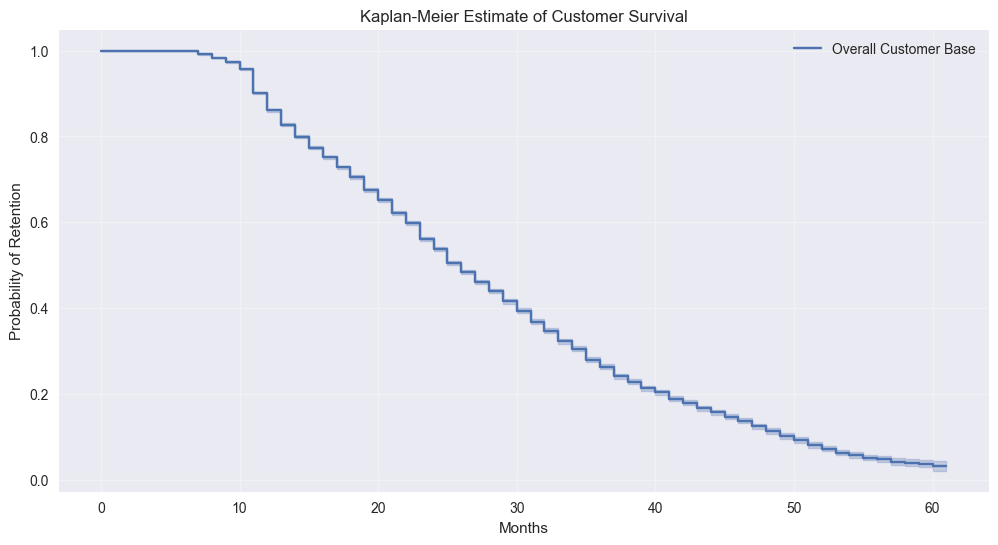

Overall survival curve saved to 'figures/overall_survival_curve.png'

Survival function (first 5 rows):


,Overall Customer Base
timeline,
0.0,1.000000
7.0,0.991774
8.0,0.982993
9.0,0.973111
10.0,0.956549
11.0,0.902015
12.0,0.861218
13.0,0.827442
14.0,0.799127



Confidence intervals (first 5 rows):


,Overall Customer Base_lower_0.95,Overall Customer Base_upper_0.95
0.0,1.000000,1.000000
7.0,0.990981,0.992497
8.0,0.981868,0.984050
9.0,0.971703,0.974451
10.0,0.954765,0.958264
11.0,0.899385,0.904579
12.0,0.858138,0.864236
13.0,0.824054,0.830772
14.0,0.795509,0.802689
15.0,0.770528,0.778078


In [16]:
# Instantiate the KaplanMeierFitter
kmf = KaplanMeierFitter()

# Fit the model
# 'months' is our duration column
# 'churn' is our event indicator (1 = churned, 0 = still active/censored)
kmf.fit(df['months'], df['churn'], label='Overall Customer Base')

# Plot the survival function
plt.figure(figsize=(12, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Estimate of Customer Survival')
plt.xlabel('Months')
plt.ylabel('Probability of Retention')
plt.grid(alpha=0.3)
plt.savefig('figures/overall_survival_curve.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Overall survival curve saved to 'figures/overall_survival_curve.png'")

# Survival function
print("\nSurvival function (first 5 rows):")
display(kmf.survival_function_)

# Confidence intervals
print("\nConfidence intervals (first 5 rows):")
display(kmf.confidence_interval_)

# Stratified Analysis by Customer Segments

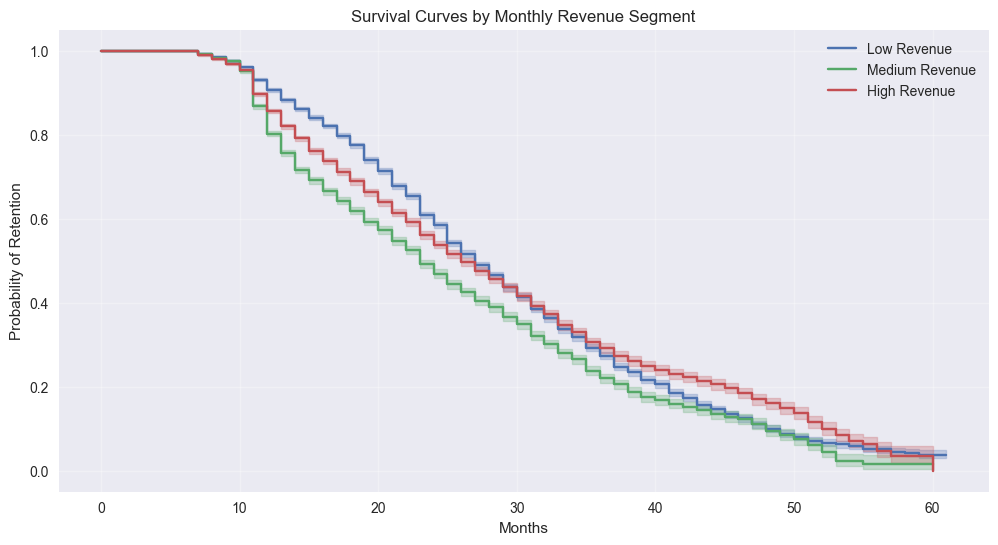

Revenue segment survival curves saved to 'figures/revenue_segment_survival.png'
Skipping segment 'Low' — non-numeric data.
Skipping segment 'High' — non-numeric data.
Skipping segment 'Medium' — non-numeric data.


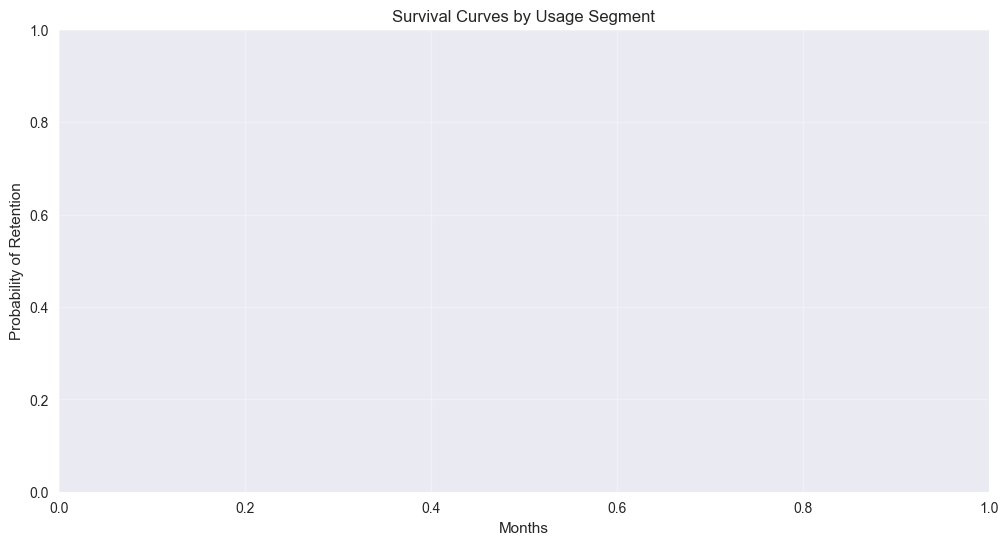

Usage segment survival curves saved to 'figures/usage_segment_survival.png'


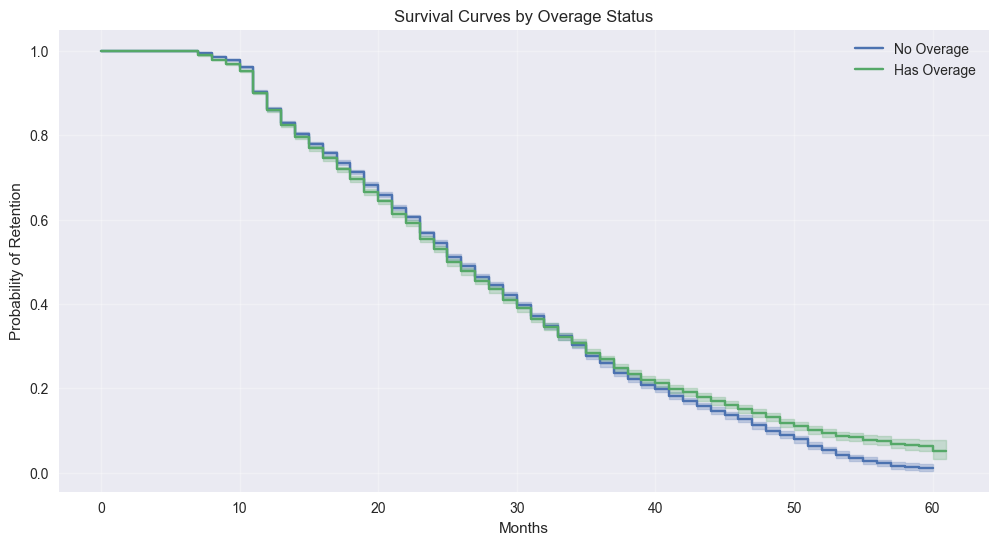

Overage status survival curves saved to 'figures/overage_survival.png'

Logrank test results for Low vs High Revenue:
p-value: 0.0000
Logrank test results for No Overage vs Has Overage:
p-value: 0.7916


In [17]:
# 4.1 Segment by Monthly Revenue (totmrc_Mean)
# Create high and low value customer segments
df['revenue_segment'] = pd.qcut(df['totmrc_Mean'], 3, labels=['Low', 'Medium', 'High'])

# Plot survival curves by revenue segment
plt.figure(figsize=(12, 6))

for segment in df['revenue_segment'].unique():
    segment_mask = (df['revenue_segment'] == segment)
    durations = df.loc[segment_mask, 'months']
    events = df.loc[segment_mask, 'churn']
    
    if durations.empty or events.empty:
        continue

    kmf = KaplanMeierFitter()
    kmf.fit(durations, events, label=f'{segment} Revenue')
    kmf.plot_survival_function()


plt.title('Survival Curves by Monthly Revenue Segment')
plt.xlabel('Months')
plt.ylabel('Probability of Retention')
plt.grid(alpha=0.3)
plt.savefig('figures/revenue_segment_survival.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Revenue segment survival curves saved to 'figures/revenue_segment_survival.png'")

# 4.2 Segment by Minutes of Use (mou_Mean)
df['usage_segment'] = pd.qcut(df['mou_Mean'], 3, labels=['Low', 'Medium', 'High'])

# Plot survival curves by usage segment
plt.figure(figsize=(12, 6))

for segment in df['usage_segment'].dropna().unique():
    segment_mask = (df['usage_segment'] == segment)
    durations = df.loc[segment_mask, 'months']
    events = df.loc[segment_mask, 'churn']

    # Skip if durations or events are empty or non-numeric
    if durations.empty or events.empty:
        print(f"Skipping segment '{segment}' — no data.")
        continue
    if not np.issubdtype(durations.dtype, np.number) or not np.issubdtype(events.dtype, np.number):
        print(f"Skipping segment '{segment}' — non-numeric data.")
        continue

    kmf = KaplanMeierFitter()
    kmf.fit(durations, events, label=f'{segment} Usage')
    kmf.plot_survival_function()

plt.title('Survival Curves by Usage Segment')
plt.xlabel('Months')
plt.ylabel('Probability of Retention')
plt.grid(alpha=0.3)
plt.savefig('figures/usage_segment_survival.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Usage segment survival curves saved to 'figures/usage_segment_survival.png'")

# 4.3 Segment by Overage Minutes (ovrmou_Mean)
# First, categorize customers into those with overage and those without
df['has_overage'] = (df['ovrmou_Mean'] > 0).astype(int)

# Plot survival curves by overage status
plt.figure(figsize=(12, 6))

# For customers with no overage
kmf_no_overage = KaplanMeierFitter()
mask_no_overage = (df['has_overage'] == 0)
kmf_no_overage.fit(df.loc[mask_no_overage, 'months'],
                  df.loc[mask_no_overage, 'churn'],
                  label='No Overage')
kmf_no_overage.plot_survival_function()

# For customers with overage
kmf_overage = KaplanMeierFitter()
mask_overage = (df['has_overage'] == 1)
kmf_overage.fit(df.loc[mask_overage, 'months'],
               df.loc[mask_overage, 'churn'],
               label='Has Overage')
kmf_overage.plot_survival_function()

plt.title('Survival Curves by Overage Status')
plt.xlabel('Months')
plt.ylabel('Probability of Retention')
plt.grid(alpha=0.3)
plt.savefig('figures/overage_survival.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Overage status survival curves saved to 'figures/overage_survival.png'")

# Perform logrank test to compare groups
# Revenue segments
low_rev = df[df['revenue_segment'] == 'Low']
high_rev = df[df['revenue_segment'] == 'High']

results = logrank_test(low_rev['months'], high_rev['months'], 
                     low_rev['churn'], high_rev['churn'])
print("\nLogrank test results for Low vs High Revenue:")
print(f"p-value: {results.p_value:.4f}")

# Overage status
no_overage = df[df['has_overage'] == 0]
has_overage = df[df['has_overage'] == 1]

results = logrank_test(no_overage['months'], has_overage['months'], 
                     no_overage['churn'], has_overage['churn'])
print("Logrank test results for No Overage vs Has Overage:")
print(f"p-value: {results.p_value:.4f}")

In [18]:
df['income']

0        5.0
1        6.0
2        6.0
3        9.0
4        9.0
        ... 
54697    3.0
54698    6.0
54699    6.0
54700    7.0
54701    2.0
Name: income, Length: 54702, dtype: float64

In [23]:
df['income_bin'] = pd.cut(df['income'], bins=3, labels=['Low Income', 'Mid Income', 'High Income'])
df['hnd_price_bin'] = pd.qcut(df['hnd_price'], q=3, labels=['Budget', 'Midrange', 'Premium'])
df['eqp_age_bin'] = pd.qcut(df['eqpdays'], q=3, labels=['New', 'Medium', 'Old'])
df['usage_bin'] = pd.cut(df['avg3mou'], bins=4, labels=['Very Low', 'Low', 'High', 'Very High'])



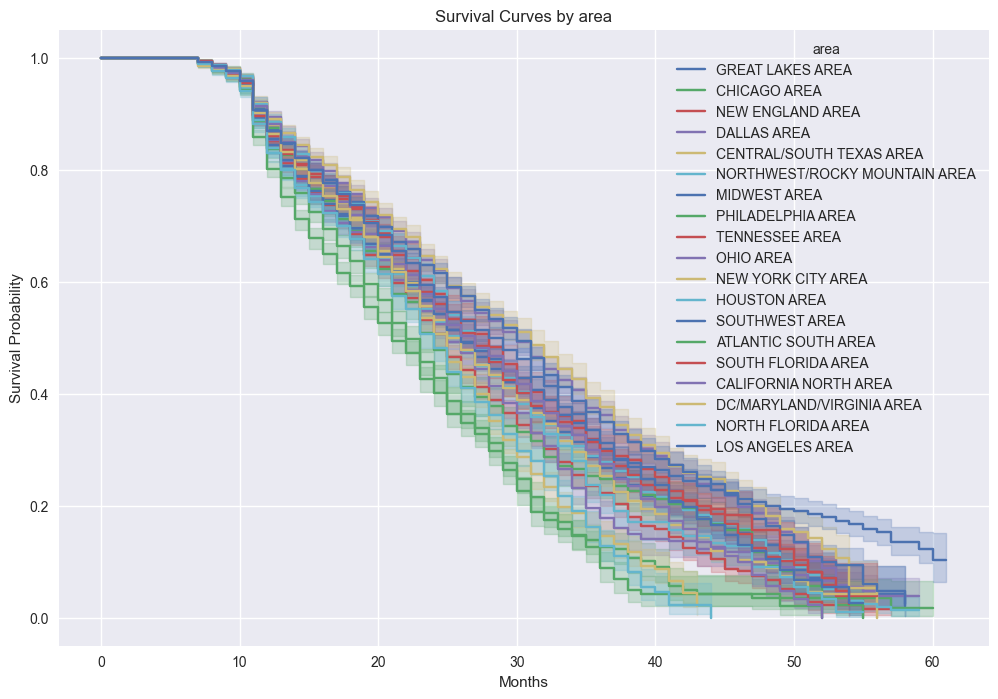

    rank                           area  survival_probability
1    1.0                   CHICAGO AREA              0.226104
13   2.0            ATLANTIC SOUTH AREA              0.247643
16   3.0      DC/MARYLAND/VIRGINIA AREA              0.287073
17   4.0             NORTH FLORIDA AREA              0.297453
7    5.0              PHILADELPHIA AREA              0.331432
2    6.0               NEW ENGLAND AREA              0.344809
9    7.0                      OHIO AREA              0.366061
5    8.0  NORTHWEST/ROCKY MOUNTAIN AREA              0.381050
10   9.0             NEW YORK CITY AREA              0.388772
0   10.0               GREAT LAKES AREA              0.400879
14  11.0             SOUTH FLORIDA AREA              0.400902
11  12.0                   HOUSTON AREA              0.403222
15  13.0          CALIFORNIA NORTH AREA              0.417812
8   14.0                 TENNESSEE AREA              0.427667
12  15.0                 SOUTHWEST AREA              0.428632
18  16.0

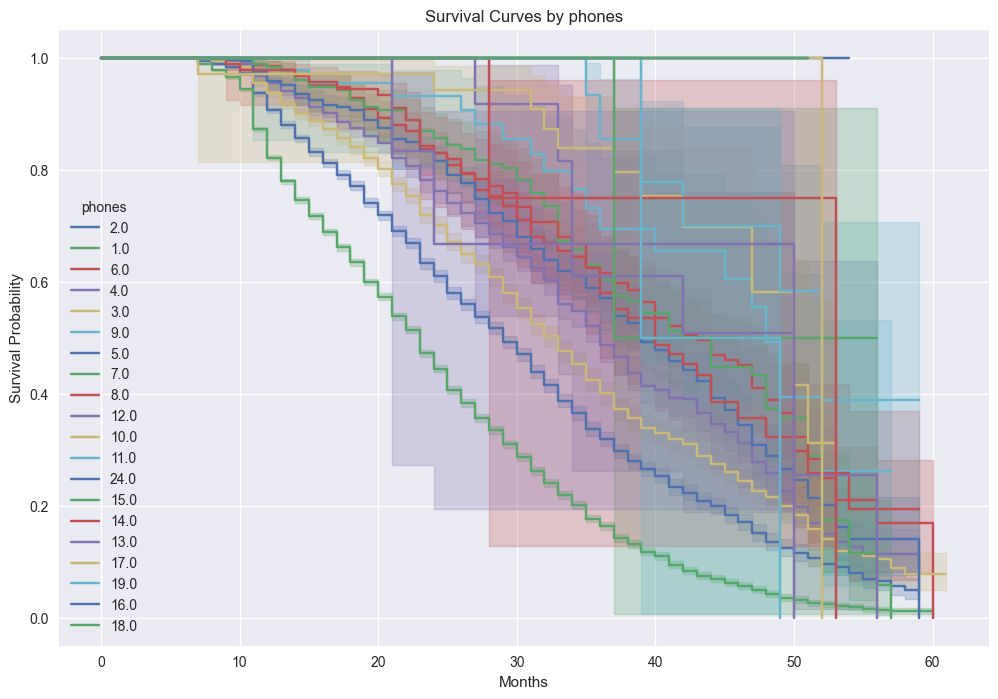

    rank  phones  survival_probability
1    1.0     1.0              0.287548
0    2.0     2.0              0.470372
4    3.0     3.0              0.553669
3    4.0     4.0              0.644857
15   5.0    13.0              0.666667
6    6.0     5.0              0.680320
2    7.0     6.0              0.710318
8    8.0     8.0              0.732942
14   9.0    14.0              0.750000
7   10.0     7.0              0.781645
5   11.0     9.0              0.855548
9   12.0    12.0              0.916667
10  13.0    10.0              0.941991
11  14.0    11.0              1.000000
13  14.0    15.0              1.000000
12  14.0    24.0              1.000000
16  14.0    17.0              1.000000
17  14.0    19.0              1.000000
18  14.0    16.0              1.000000
19  14.0    18.0              1.000000


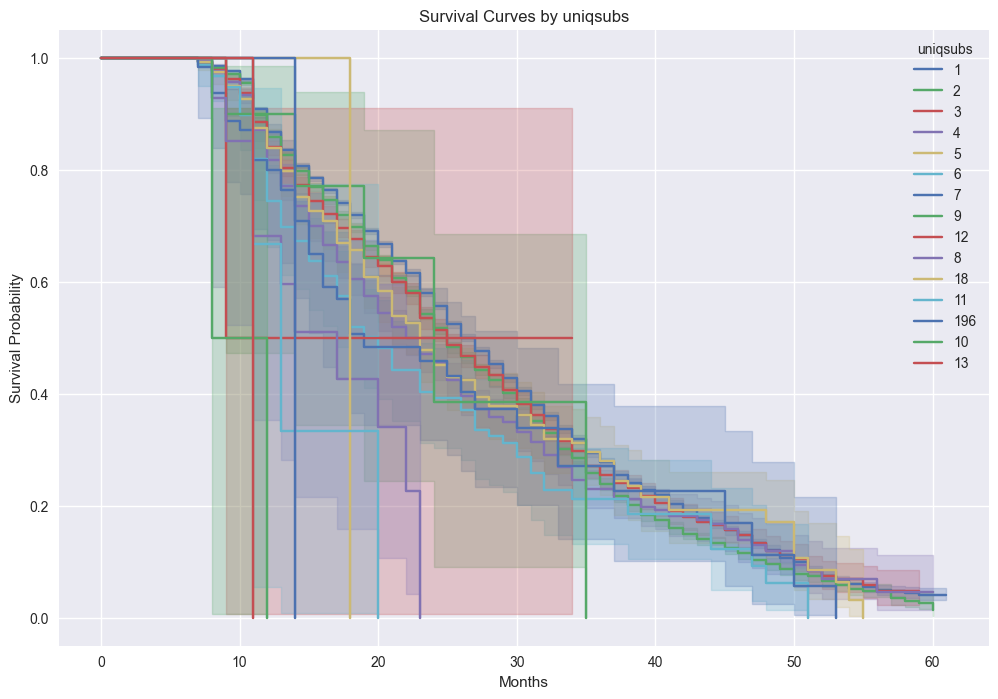

    rank  uniqsubs  survival_probability
12   1.0       196              0.000000
11   1.0        11              0.000000
13   1.0        10              0.000000
14   1.0        13              0.000000
10   1.0        18              0.000000
9    1.0         8              0.000000
5    7.0         6              0.286754
3    8.0         4              0.331293
6    9.0         7              0.338197
4   10.0         5              0.361496
2   11.0         3              0.381432
1   12.0         2              0.382995
7   13.0         9              0.385714
0   14.0         1              0.404994
8   15.0        12              0.500000


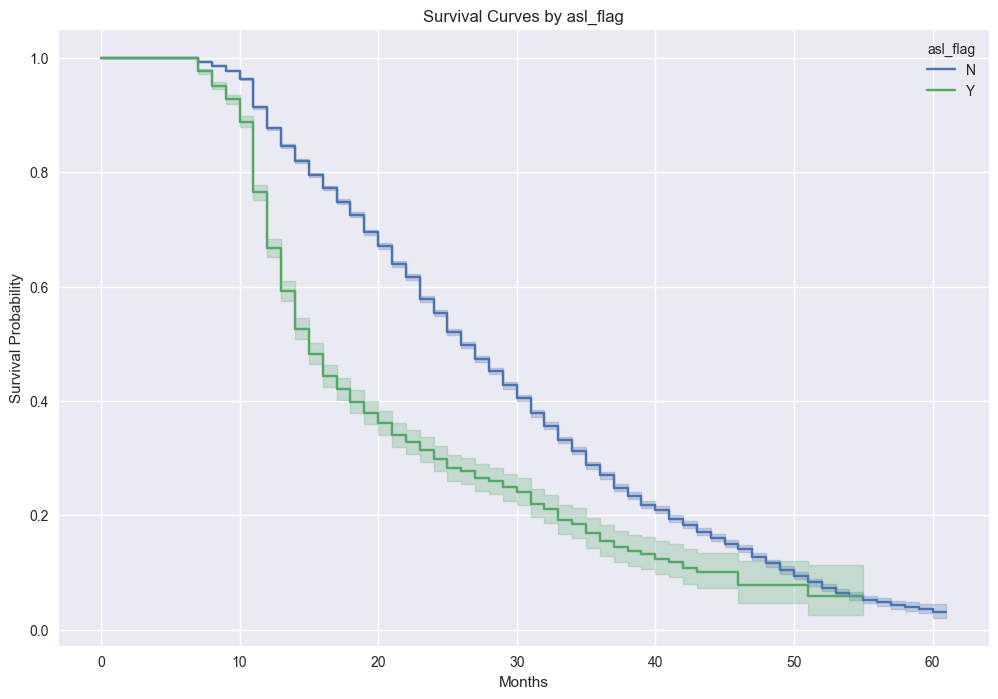

   rank asl_flag  survival_probability
1   1.0        Y              0.241113
0   2.0        N              0.405030


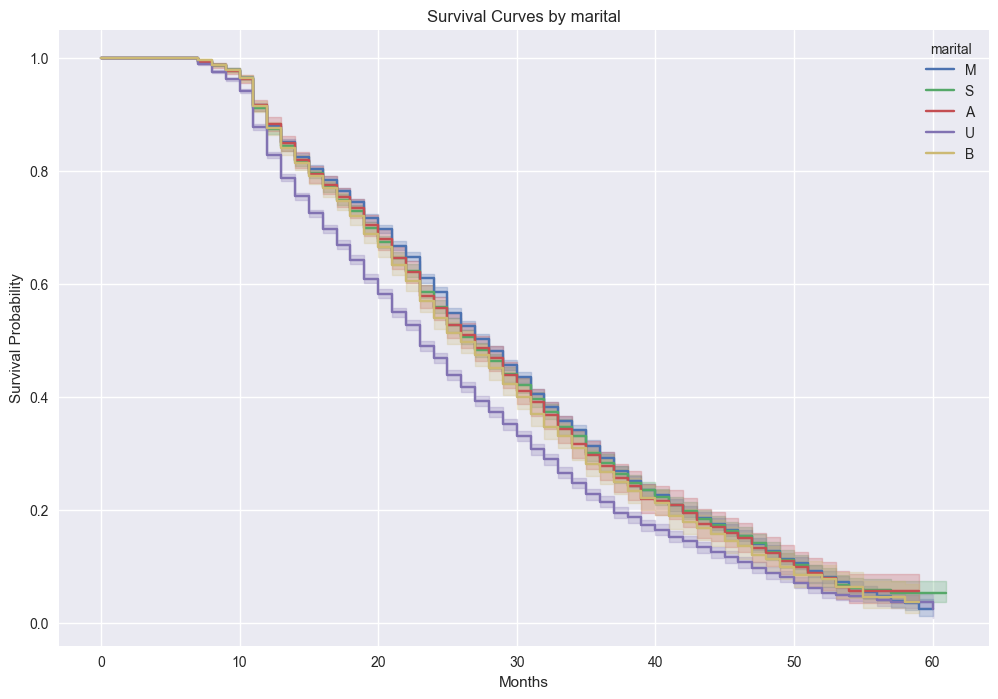

   rank marital  survival_probability
3   1.0       U              0.330597
4   2.0       B              0.399399
2   3.0       A              0.410007
1   4.0       S              0.420351
0   5.0       M              0.434564


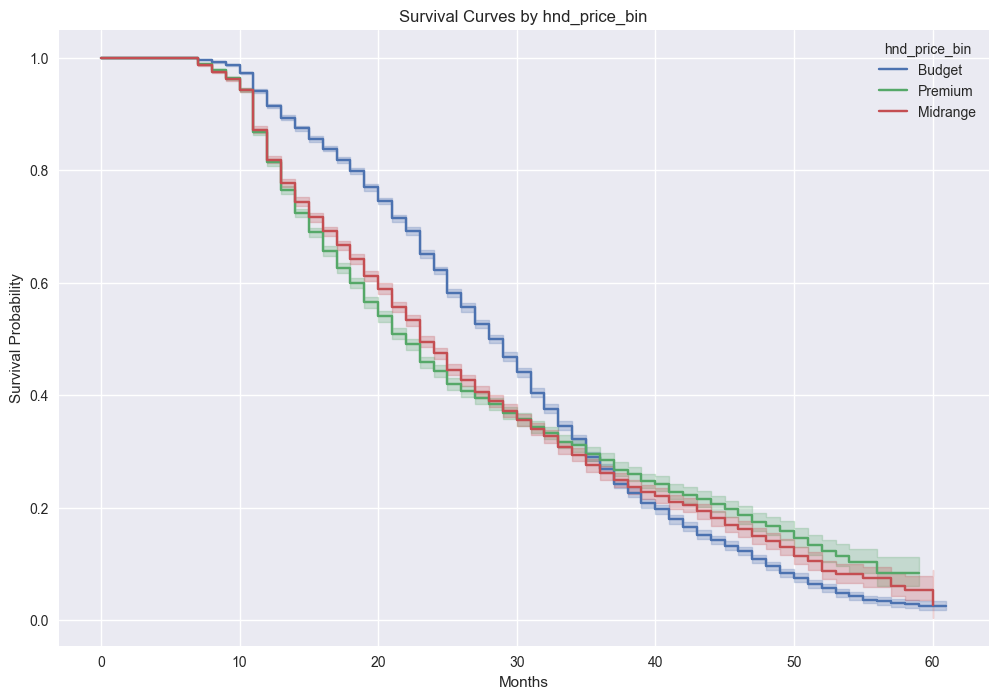

   rank hnd_price_bin  survival_probability
2   1.0      Midrange              0.355929
1   2.0       Premium              0.357050
0   3.0        Budget              0.440584


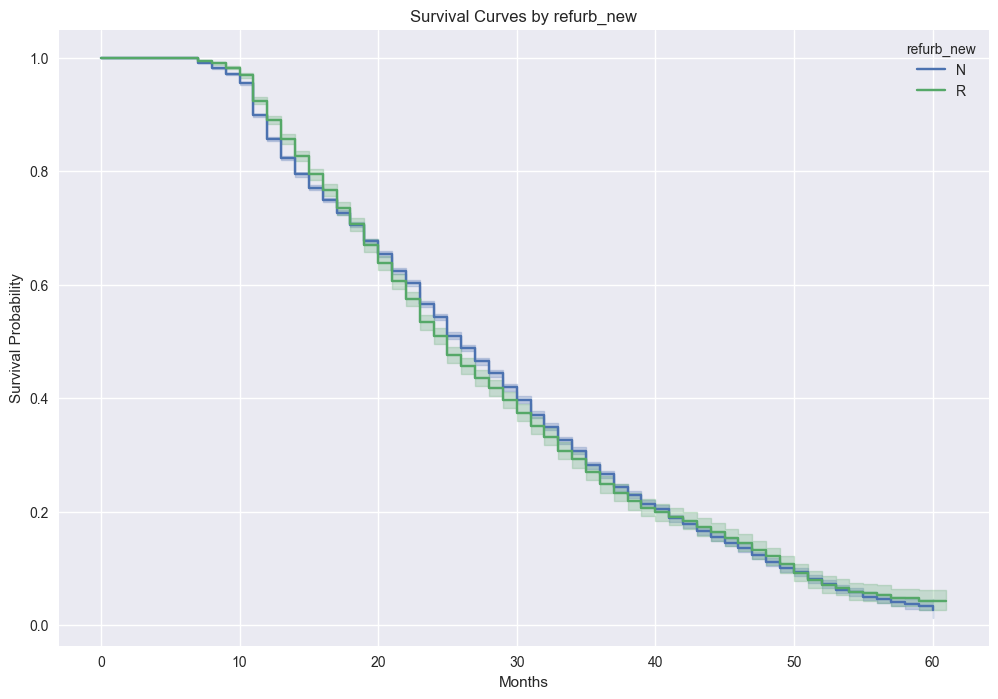

   rank refurb_new  survival_probability
1   1.0          R              0.374391
0   2.0          N              0.397567


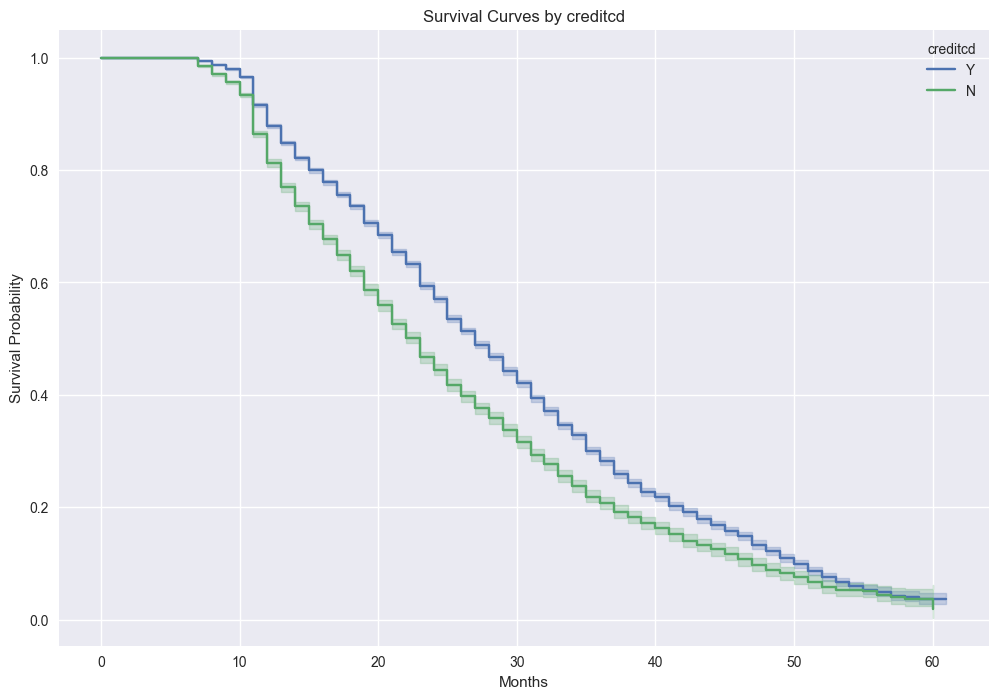

   rank creditcd  survival_probability
1   1.0        N              0.316320
0   2.0        Y              0.420729


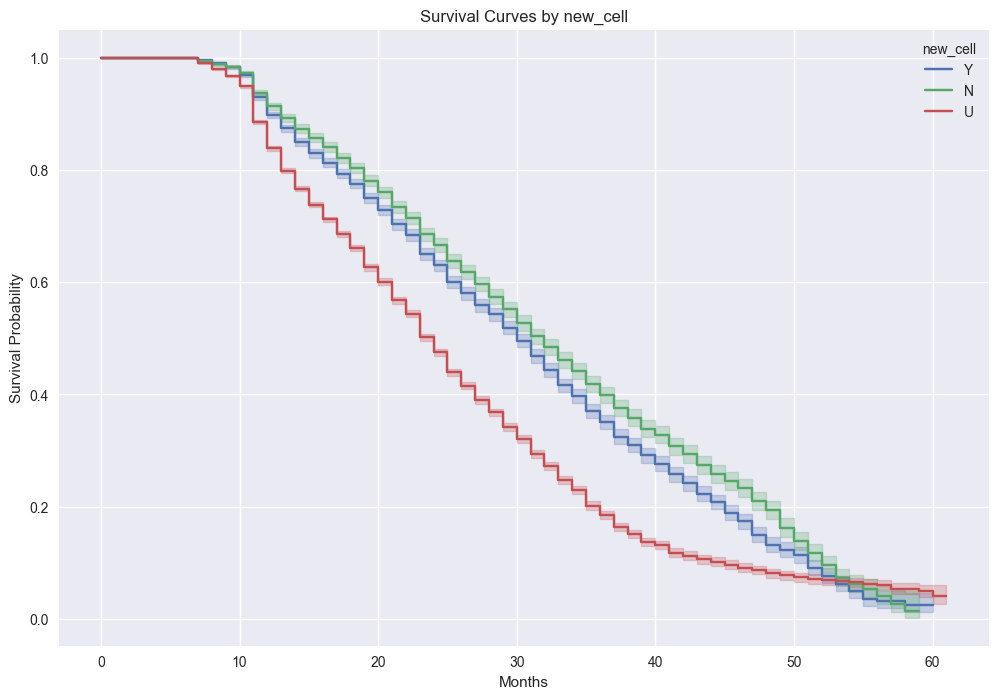

   rank new_cell  survival_probability
2   1.0        U              0.320911
0   2.0        Y              0.496032
1   3.0        N              0.527499


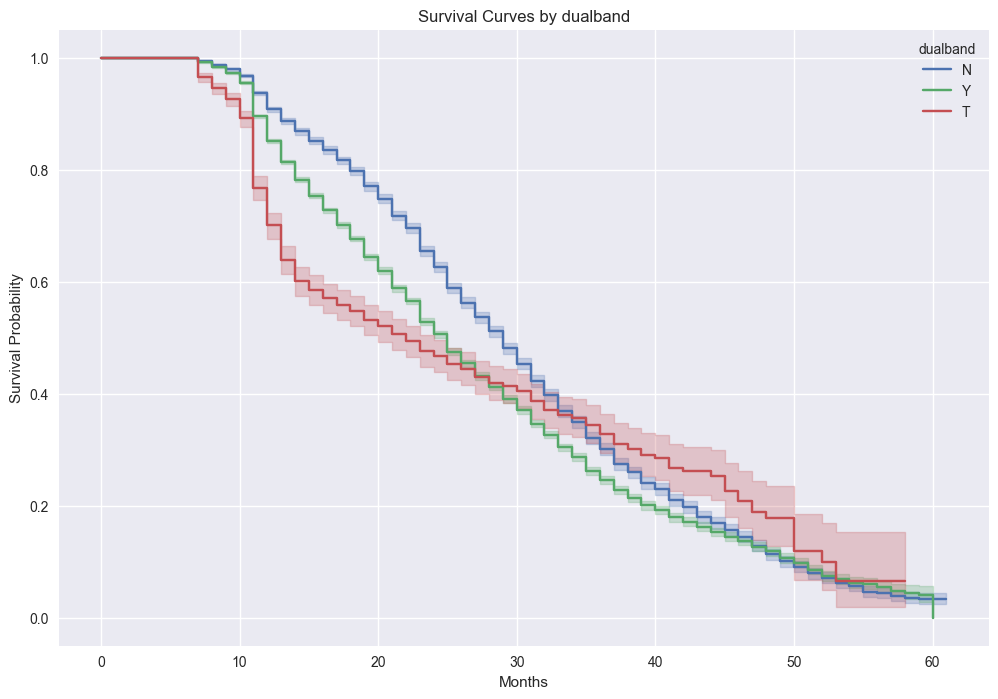

   rank dualband  survival_probability
1   1.0        Y              0.371055
2   2.0        T              0.405126
0   3.0        N              0.453737


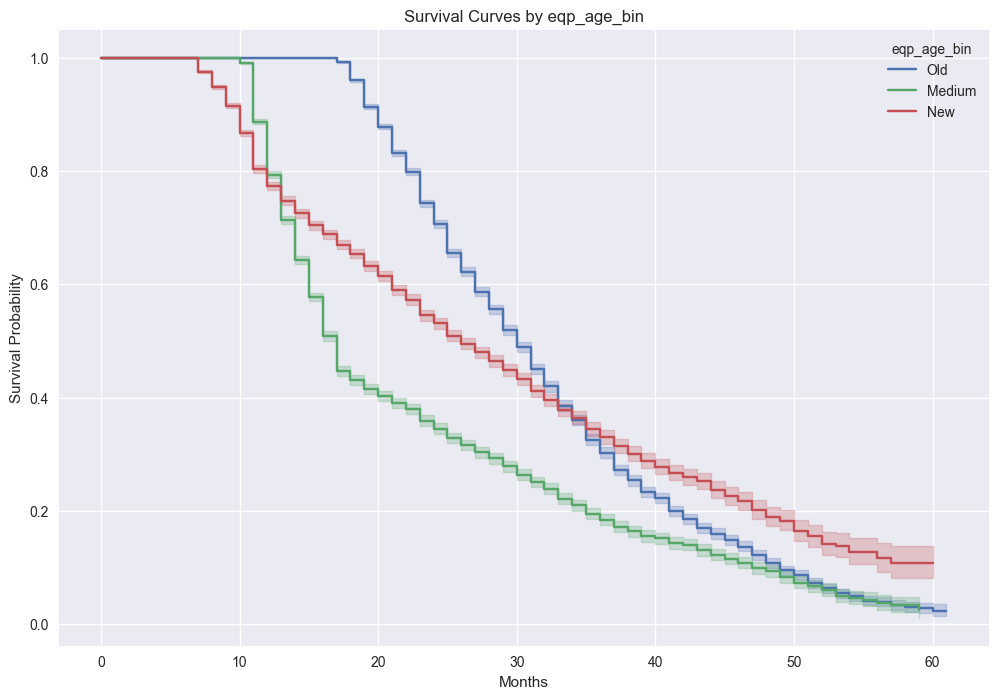

   rank eqp_age_bin  survival_probability
1   1.0      Medium              0.263838
2   2.0         New              0.433532
0   3.0         Old              0.488810


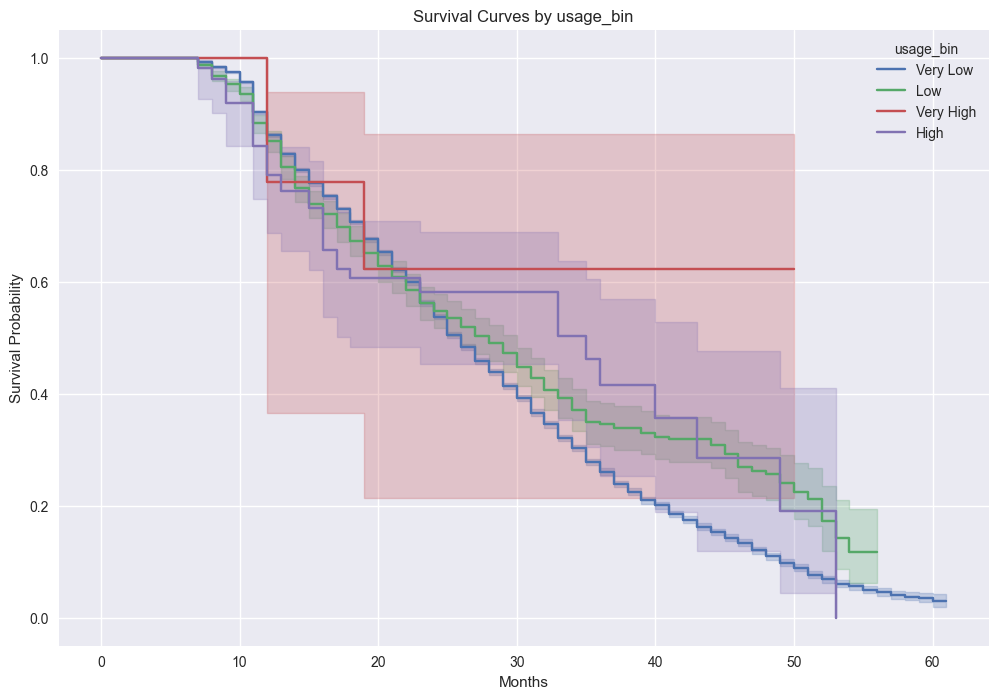

   rank  usage_bin  survival_probability
0   1.0   Very Low              0.392612
1   2.0        Low              0.447572
3   3.0       High              0.581294
2   4.0  Very High              0.622222


In [24]:
ssegmentation_vars = [
    'area',
    'phones',
    'uniqsubs',
    'asl_flag',
    'marital',
    'hnd_price_bin',     # Binned: Budget, Midrange, Premium
    'refurb_new',
    'creditcd',
    'new_cell',
    'dualband',
    'eqp_age_bin',       # Binned: <1 year, 1–2 years, 2+ years
    'usage_bin'          # Binned: Very Low, Low, High, Very High
]

for i in ssegmentation_vars:
    plt.figure(figsize=(12, 8))  

    for segment in df[i].dropna().unique():
        kmf.fit(df[df[i] == segment]['months'],
                df[df[i] == segment]['churn'],
                label=str(segment))
        kmf.plot_survival_function()

    plt.title(f'Survival Curves by {i}')
    plt.xlabel('Months')
    plt.ylabel('Survival Probability')
    plt.legend(title=f'{i}')
    plt.grid(True)
    plt.show()




    time_point = 30

    survival_probs_list = []

    for segment in df[i].dropna().unique():
        kmf.fit(df[df[i] == segment]['months'],
                df[df[i] == segment]['churn'],
                label=str(segment))
        survival_prob = kmf.survival_function_at_times([time_point]).iloc[0]
        survival_probs_list.append({f'{i}': segment, 'survival_probability': survival_prob})

    survival_probs = pd.DataFrame(survival_probs_list)

    survival_probs = survival_probs.sort_values(by='survival_probability', ascending=True)
    survival_probs['rank'] = survival_probs['survival_probability'].rank(method='min')

    print(survival_probs[['rank', f'{i}', 'survival_probability']])




# Statistical Testing

In [27]:
def perform_logrank_tests(df, duration_col='months', event_col='churn'):
    """
    Perform log-rank tests to statistically compare survival curves between groups.
    """
    print("\nSTATISTICAL TESTING WITH LOG-RANK TESTS")
    print("-" * 50)
    
    # 1. Simple variable groups
    simple_vars = {
        'new_cell': ['Y', 'N'],
        'asl_flag': ['Y', 'N'],
        'dualband': ['Y', 'N']
    }
    
    print("Log-rank Tests for Simple Group Comparisons:")
    for var, groups in simple_vars.items():
        if all(g in df[var].unique() for g in groups):
            # Extract data for the two groups
            group1 = df[df[var] == groups[0]]
            group2 = df[df[var] == groups[1]]
            
            # Perform log-rank test
            results = logrank_test(
                group1[duration_col], group2[duration_col],
                group1[event_col], group2[event_col]
            )
            
            # Print results
            print(f"\n{var} - {groups[0]} vs {groups[1]}:")
            print(f"  Test statistic: {results.test_statistic:.4f}")
            print(f"  P-value: {results.p_value:.4f}")
            print(f"  Statistical significance: {'Yes' if results.p_value < 0.05 else 'No'}")
    
    # 2. Advanced segments from the previous function
    print("\nLog-rank Tests for Advanced Segments:")
    segments_to_test = [
        ('high_value', 'High Value', 'Low Value'),
        ('poor_quality', 'Poor Quality', 'Good Quality'),
        ('high_value_poor_quality', 'High Value with Poor Quality', 'Others')
    ]
    
    for segment, label1, label2 in segments_to_test:
        # Extract data for the two groups
        group1 = df[df[segment]]
        group2 = df[~df[segment]]
        
        # Perform log-rank test
        results = logrank_test(
            group1[duration_col], group2[duration_col],
            group1[event_col], group2[event_col]
        )
        
        # Print results
        print(f"\n{label1} vs {label2}:")
        print(f"  Test statistic: {results.test_statistic:.4f}")
        print(f"  P-value: {results.p_value:.4f}")
        print(f"  Statistical significance: {'Yes' if results.p_value < 0.05 else 'No'}")
    
    # 3. Pairwise comparisons for multi-category variable
    print("\nPairwise Log-rank Tests for Multi-category Variable:")
    # Example with prizm_social_one (if it has multiple categories)
    if 'prizm_social_one' in df.columns:
        categories = df['prizm_social_one'].unique()
        if len(categories) > 1:
            print(f"Pairwise comparisons for prizm_social_one ({len(categories)} categories):")
            
            # Create a matrix to store p-values
            n_categories = len(categories)
            p_values = np.zeros((n_categories, n_categories))
            
            # Perform pairwise log-rank tests
            for i in range(n_categories):
                for j in range(i+1, n_categories):
                    cat_i = categories[i]
                    cat_j = categories[j]
                    
                    group_i = df[df['prizm_social_one'] == cat_i]
                    group_j = df[df['prizm_social_one'] == cat_j]
                    
                    if len(group_i) > 0 and len(group_j) > 0:
                        results = logrank_test(
                            group_i[duration_col], group_j[duration_col],
                            group_i[event_col], group_j[event_col]
                        )
                        
                        print(f"  {cat_i} vs {cat_j}:")
                        print(f"    Test statistic: {results.test_statistic:.4f}")
                        print(f"    P-value: {results.p_value:.4f}")
                        print(f"    Statistical significance: {'Yes' if results.p_value < 0.05 else 'No'}")
                        
                        # Store p-value
                        p_values[i, j] = results.p_value
                        p_values[j, i] = results.p_value
            
            # Plot heatmap of p-values if there are multiple categories
            if n_categories > 2:
                plt.figure(figsize=(10, 8))
                sns.heatmap(p_values, annot=True, cmap='YlGnBu', 
                            xticklabels=categories, yticklabels=categories)
                plt.title('P-values from Pairwise Log-rank Tests')
                plt.tight_layout()
                plt.savefig('logrank_pvalues_heatmap.png')
                plt.show()
                plt.close()
                print("\nHeatmap of p-values from pairwise log-rank tests has been saved as 'logrank_pvalues_heatmap.png'")


perform_logrank_tests(df, duration_var, event_var)


STATISTICAL TESTING WITH LOG-RANK TESTS
--------------------------------------------------
Log-rank Tests for Simple Group Comparisons:

new_cell - Y vs N:
  Test statistic: 37.5720
  P-value: 0.0000
  Statistical significance: Yes

asl_flag - Y vs N:
  Test statistic: 1490.0934
  P-value: 0.0000
  Statistical significance: Yes

dualband - Y vs N:
  Test statistic: 349.4171
  P-value: 0.0000
  Statistical significance: Yes

Log-rank Tests for Advanced Segments:


KeyError: 'high_value'

# Parametric Survival Models

In [29]:
# Prepare the data for parametric models
# Select important predictors based on domain knowledge and data exploration
predictors = ['totmrc_Mean', 'mou_Mean', 'ovrmou_Mean', 'rev_Mean', 'drop_vce_Mean', 'custcare_Mean']

# Create a dataframe with predictors, duration and event indicator
model_df = df[predictors + ['months', 'churn']].copy()

# Check for missing values in the modeling dataset
print("Missing values in the modeling dataset:")
print(model_df.isnull().sum())

# Drop rows with missing values
model_df = model_df.dropna()
print(f"Shape after dropping missing values: {model_df.shape}")

# 5.1 Fit Weibull AFT model
print("\nFitting Weibull AFT model...")
waft = WeibullAFTFitter()
waft.fit(model_df, duration_col='months', event_col='churn')

# Display model summary
print("Weibull AFT Model Summary:")
waft_summary = waft.summary
print(waft_summary)
waft_summary.to_csv('weibull_model_summary.csv')

# 5.2 Fit Log-Logistic AFT model
print("\nFitting Log-Logistic AFT model...")
llaft = LogLogisticAFTFitter()
llaft.fit(model_df, duration_col='months', event_col='churn')

# Display model summary
print("Log-Logistic AFT Model Summary:")
llaft_summary = llaft.summary
print(llaft_summary)
llaft_summary.to_csv('loglogistic_model_summary.csv')

# 5.3 Fit Exponential model
print("\nFitting Exponential model...")
exp_fit = ExponentialFitter()
exp_fit.fit(model_df['months'], model_df['churn'])

# Display model fit
print("Exponential Model:")
print(f"Lambda (rate parameter): {exp_fit.lambda_}")

# 5.4 Compare models using AIC
print("\nModel Comparison using AIC:")
print(f"Weibull AFT AIC: {waft.AIC_}")
print(f"Log-Logistic AFT AIC: {llaft.AIC_}")

# Save model comparison to text file
with open('model_comparison.txt', 'w') as f:
    f.write("Model Comparison using AIC:\n")
    f.write(f"Weibull AFT AIC: {waft.AIC_}\n")
    f.write(f"Log-Logistic AFT AIC: {llaft.AIC_}\n")
    f.write(f"Exponential lambda: {exp_fit.lambda_}\n")

# Plot the predicted survival curves of the different models
plt.figure(figsize=(12, 6))

# Original KM curve
kmf = KaplanMeierFitter()
kmf.fit(model_df['months'], model_df['churn'], label='KM Estimate')
kmf.plot_survival_function()

# Weibull predicted curve
waft_pred = waft.predict_survival_function(model_df.iloc[:1])
plt.plot(waft_pred.index, waft_pred.iloc[:, 0], label='Weibull AFT')

# Log-Logistic predicted curve
llaft_pred = llaft.predict_survival_function(model_df.iloc[:1])
plt.plot(llaft_pred.index, llaft_pred.iloc[:, 0], label='Log-Logistic AFT')

plt.title('Comparison of Parametric Survival Models')
plt.xlabel('Months')
plt.ylabel('Survival Probability')
plt.grid(alpha=0.3)
plt.legend()
plt.savefig('figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.close()

Missing values in the modeling dataset:
totmrc_Mean      0
mou_Mean         0
ovrmou_Mean      0
rev_Mean         0
drop_vce_Mean    0
custcare_Mean    0
months           0
churn            0
dtype: int64
Shape after dropping missing values: (54702, 8)

Fitting Weibull AFT model...
Weibull AFT Model Summary:
                           coef  exp(coef)  se(coef)  coef lower 95%  \
param   covariate                                                      
lambda_ custcare_Mean -0.002858   0.997146  0.000394       -0.003630   
        drop_vce_Mean -0.003184   0.996821  0.000572       -0.004305   
        mou_Mean       0.000072   1.000072  0.000013        0.000047   
        ovrmou_Mean   -0.001544   0.998457  0.000079       -0.001700   
        rev_Mean       0.005185   1.005198  0.000271        0.004653   
        totmrc_Mean   -0.005145   0.994868  0.000283       -0.005699   
        Intercept      3.427489  30.799204  0.005870        3.415983   
rho_    Intercept      0.829922   2.293139

# Model Selection and Interpretation

Sorted Model Coefficients by Influence Magnitude:
                           coef  exp(coef)             p
param   covariate                                       
lambda_ Intercept      3.427489  30.799204  0.000000e+00
rho_    Intercept      0.829922   2.293139  0.000000e+00
lambda_ rev_Mean       0.005185   1.005198  1.740198e-81
        totmrc_Mean   -0.005145   0.994868  6.369211e-74
        drop_vce_Mean -0.003184   0.996821  2.561260e-08
        custcare_Mean -0.002858   0.997146  3.810159e-13
        ovrmou_Mean   -0.001544   0.998457  3.467385e-84
        mou_Mean       0.000072   1.000072  2.013366e-08


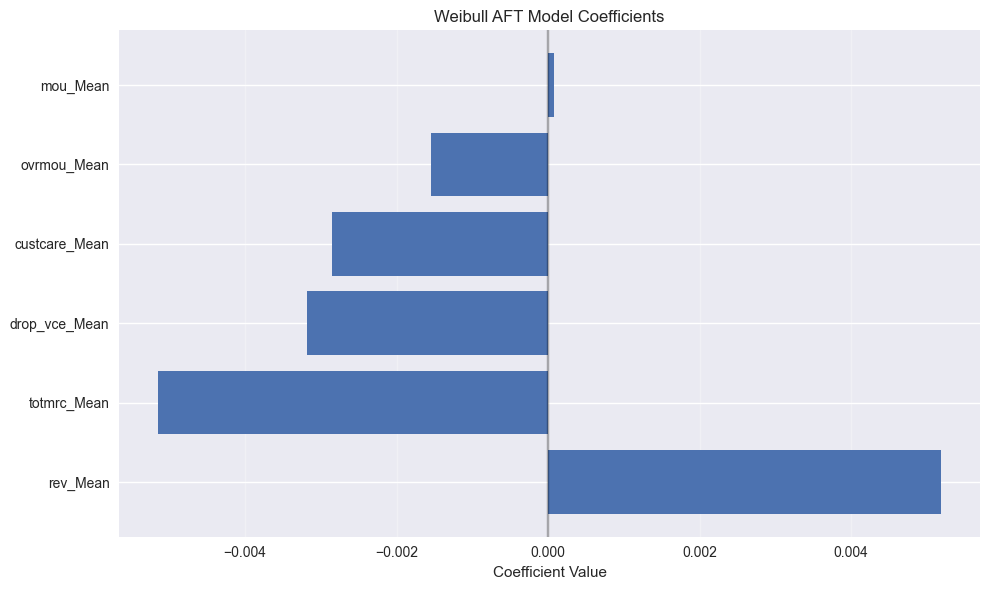

Model coefficients plot saved to 'figures/model_coefficients.png'


In [31]:
# Interpret the coefficients of the Weibull model
waft_summary = waft.summary

# Sort by absolute value of coef to identify most influential factors
waft_summary['abs_coef'] = waft_summary['coef'].abs()
waft_summary = waft_summary.sort_values('abs_coef', ascending=False)

# Display sorted coefficients
print("Sorted Model Coefficients by Influence Magnitude:")
print(waft_summary[['coef', 'exp(coef)', 'p']])

# Save sorted coefficients to CSV
waft_summary[['coef', 'exp(coef)', 'p', 'abs_coef']].to_csv('sorted_coefficients.csv')

# Visualize coefficient effects
plt.figure(figsize=(10, 6))
coefs = waft_summary['coef']
exp_coefs = waft_summary['exp(coef)']
variables = coefs.index.get_level_values(1)

# Removing the intercept for better visualization
mask = variables != 'Intercept'
coefs = coefs[mask]
exp_coefs = exp_coefs[mask]
variables = variables[mask]

plt.barh(variables, coefs)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.title('Weibull AFT Model Coefficients')
plt.xlabel('Coefficient Value')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/model_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Model coefficients plot saved to 'figures/model_coefficients.png'")